Saving PublishPerish_fixed.xlsx to PublishPerish_fixed (3).xlsx


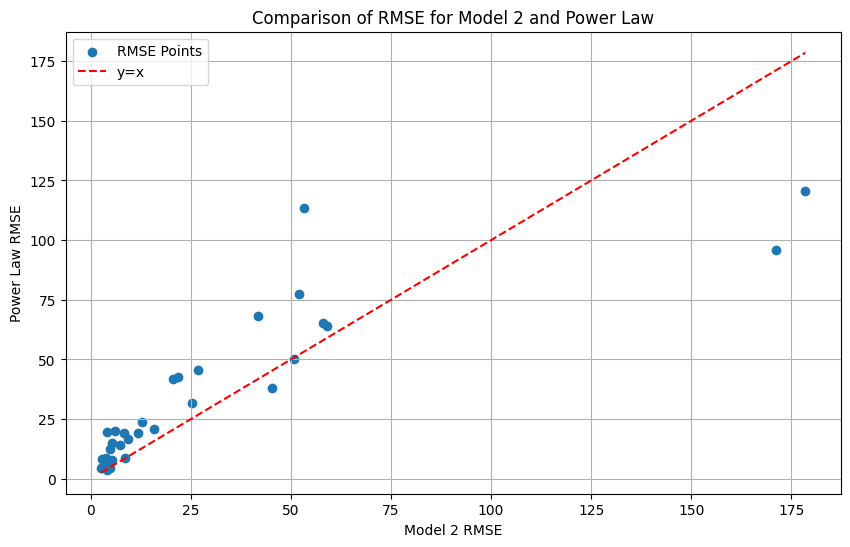

In [7]:
!pip install pandas numpy matplotlib python-docx openpyxl scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from scipy.optimize import minimize

uploaded = files.upload()

file_name = list(uploaded.keys())[0]
xls = pd.ExcelFile(file_name)

def calculate_h_index(y_data):
    sorted_cites = np.sort(y_data)[::-1]
    h_index = np.max(np.where(sorted_cites >= np.arange(1, len(sorted_cites) + 1))[0]) + 1
    return h_index

def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def optimize_abc(x_data, y_data):
    def objective(params):
        a, b, c = params
        fitted_values = (b / (x_data + c)) - a
        return calculate_rmse(y_data, fitted_values)

    initial_guess = [0.1, 100, 72]
    result = minimize(objective, initial_guess, method='Nelder-Mead')
    return result.x

def optimize_power_law(x_data, y_data):
    M = np.max(y_data)
    def objective(params):
        C, lam = params
        fitted_values = C / (x_data ** lam)
        return calculate_rmse(y_data, fitted_values)

    initial_guess = [M, 1]
    result = minimize(objective, initial_guess, method='Nelder-Mead')
    return result.x

optimized_model_df = pd.DataFrame(columns=['Sheet', 'a_opt', 'b_opt', 'c_opt', 'RMSEEQN2'])
power_law_model_df = pd.DataFrame(columns=['Sheet', 'C_opt', 'lambda_opt', 'RMSE_PowerLaw'])

for sheet_name in xls.sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet_name)
    x_data = df['Serial Number'].values
    y_data = df['ECC'].values

    a_opt, b_opt, c_opt = optimize_abc(x_data, y_data)
    fitted_values_opt = (b_opt / (x_data + c_opt)) - a_opt
    rmse_eqn2 = calculate_rmse(y_data, fitted_values_opt)

    C_opt, lambda_opt = optimize_power_law(x_data, y_data)
    fitted_values_power_law = C_opt / (x_data ** lambda_opt)
    rmse_power_law = calculate_rmse(y_data, fitted_values_power_law)

    optimized_row = pd.DataFrame({
        'Sheet': [sheet_name],
        'a_opt': [a_opt],
        'b_opt': [b_opt],
        'c_opt': [c_opt],
        'RMSEEQN2': [rmse_eqn2]
    })
    optimized_model_df = pd.concat([optimized_model_df, optimized_row], ignore_index=True)

    power_law_row = pd.DataFrame({
        'Sheet': [sheet_name],
        'C_opt': [C_opt],
        'lambda_opt': [lambda_opt],
        'RMSE_PowerLaw': [rmse_power_law]
    })
    power_law_model_df = pd.concat([power_law_model_df, power_law_row], ignore_index=True)

merged_df = pd.merge(optimized_model_df, power_law_model_df, on='Sheet')

plt.figure(figsize=(10, 6))
plt.scatter(merged_df['RMSEEQN2'], merged_df['RMSE_PowerLaw'], label='RMSE Points')

min_val = min(merged_df['RMSEEQN2'].min(), merged_df['RMSE_PowerLaw'].min())
max_val = max(merged_df['RMSEEQN2'].max(), merged_df['RMSE_PowerLaw'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y=x')

plt.xlabel('Model 2 RMSE')
plt.ylabel('Power Law RMSE')
plt.title('Comparison of RMSE for Model 2 and Power Law')
plt.legend()
plt.grid(True)
plt.show()
